<b><u>Domain</u></b> - E-commerce<p>
<b><u>Context</u></b> - Everyday a million products are being recommended to users based on
popularity and other metrics on e-commerce websites. The most popular e-commerce
website boosts average order value by 50%, increases revenues by 300%, and
improves conversion. In addition to being a powerful tool for increasing revenues,
product recommendations are so essential that customers now expect to see similar
features on all other eCommerce sites.<p>
<b><u>Data Description</u></b> -<br>
Data columns- First three columns are userId, productId, and ratings and the fourth
column is timestamp. You can discard the timestamp column as in this case you may
not need to use it.<p>
<b><u>Source</u></b> - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The
repository has several datasets. For this case study, we are using the Electronics
dataset.<p>
<b><u>Objective</u></b> - To make a recommendation system that recommends at least five(5)
new products based on the user's habits.
    

### Importing Libraries

In [ ]:
#!pip install "dask[complete]"

In [2]:
#!pip install scikit-surprise

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import dask.dataframe as dd
import scipy.stats as stats
import numpy as np
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(color_codes=True)
from surprise import KNNWithMeans
from surprise import Dataset, SVD ,Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
%matplotlib inline

### Functions for EDA

In [4]:
def Distribution_Continous_Variables(series,color,title):
    plt.figure(figsize=(10, 10))
    sns.distplot(series, color = color).set_title(title)
    

        
def CountPlot(**kwargs):
    plt.figure(figsize=(10, 10))
    sns.countplot(y=kwargs['y'], \
                    hue=kwargs['hue'], \
                    data=kwargs['data']).set_title(kwargs['title'])


### Importing the data

#### Since the datset is big we would use dask dataframes instead of pandas dataframe since the former is capable to perform faster groupby or other such functions

In [5]:
path = r'/content/drive/MyDrive/GL_Assignment_RecommenderSystem/ratings_Electronics.csv'

In [6]:
#df = dd.read_csv("ratings_Electronics.csv",names=['userId','productId','ratings','timestamp'])
df = pd.read_csv(path,names=['userId','productId','ratings','timestamp'])
dask_df = dd.from_pandas(df,npartitions=10)

### Exploratory Data Analysis

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [8]:
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [9]:
df.shape

(7824482, 4)

#### Total number of rows we have is 7824482

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


### Checking for null values

In [11]:
df.isnull().values.any()

False

In [12]:
df.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

#### We do not have any null values in our dataset

### Total number of users 

In [13]:
df['userId'].nunique()

4201696

In [14]:
df['userId'].value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1WH2Z5O9BU6VP      1
A3J1WIQYAH8ZD0      1
A1LUFW9ZU9VQUJ      1
A245AQWLV1HODC      1
A13RE01422J8ZF      1
Name: userId, Length: 4201696, dtype: int64

#### Let us only take the users who have given 50 or more ratings so that we can make less sparser

In [2]:
#------Dask documentation : https://examples.dask.org/------#
from dask.distributed import Client
client = Client(n_workers = 1, threads_per_worker=4, processes = False, memory_limit='4GB')
client

Client Scheduler: inproc://192.168.1.3/23064/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 4.00 GB


#### The above dashboard shows the realtime status of the resources our dask functions are utilising

In [15]:
%time df1 = dask_df.groupby('userId')['userId'].count().compute().reset_index(name='count')

CPU times: user 34.8 s, sys: 310 ms, total: 35.1 s
Wall time: 29.3 s


In [16]:
df_r = df.loc[df['userId'].isin(df1[df1['count'] >= 50]['userId'].tolist())]
dask_df_r = dd.from_pandas(df_r, npartitions = 10) #-----dask dataframe----#

In [17]:
df_r.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125871 non-null  object 
 1   productId  125871 non-null  object 
 2   ratings    125871 non-null  float64
 3   timestamp  125871 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.8+ MB


In [18]:
df_r.shape

(125871, 4)

### Let us convert the ratings into object data type

In [19]:
df_r['ratings'] = df_r['ratings'].astype('object')

In [20]:
df_r.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     125871 non-null  object
 1   productId  125871 non-null  object
 2   ratings    125871 non-null  object
 3   timestamp  125871 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.8+ MB


### Univariate analysis

#### Count Plot of ratings

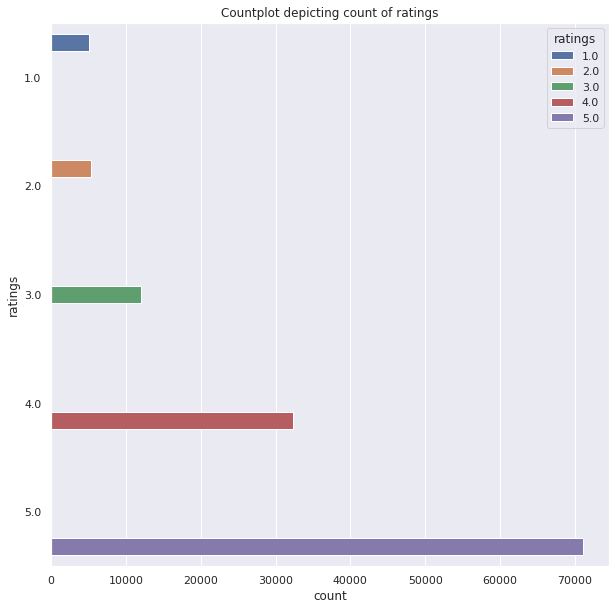

In [21]:
CountPlot(y = 'ratings', hue = 'ratings', data = df_r , title = 'Countplot depicting count of ratings' )

In [22]:
df_r['ratings'].value_counts()

5.0    71034
4.0    32295
3.0    12060
2.0     5367
1.0     5115
Name: ratings, dtype: int64

#### Distribution of ratings

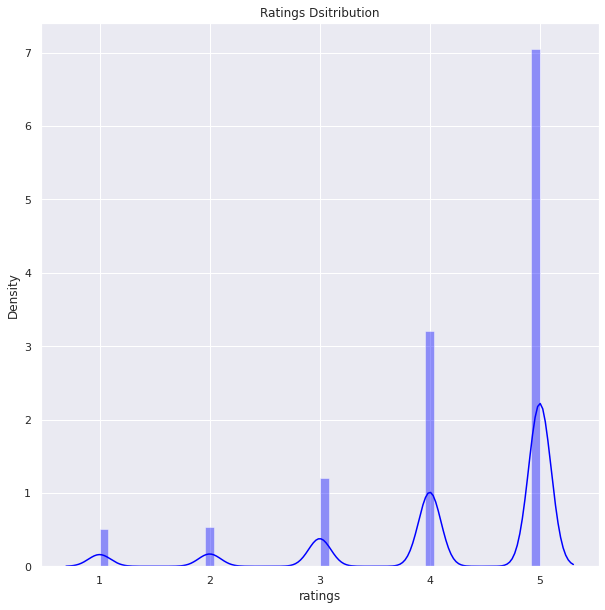

In [23]:
Distribution_Continous_Variables(df_r['ratings'],'blue','Ratings Dsitribution')

#### Average rating by product

In [24]:
data = df_r.groupby(['productId','ratings']).count().reset_index()
data['ratings'] = data['ratings'].astype('float64')
data = data.groupby(['productId'])['ratings'].agg(['min','max','count','mean','median']).reset_index().sort_values(by=['median'],ascending=True)

In [25]:
data.tail()

,productId,min,max,count,mean,median
21964,B002R0DWNS,5.0,5.0,1,5.0,5.0
21960,B002QXZPFE,5.0,5.0,1,5.0,5.0
21958,B002QWNZHU,5.0,5.0,1,5.0,5.0
21954,B002QUZM3M,5.0,5.0,1,5.0,5.0
48189,B00LKG1MC8,5.0,5.0,1,5.0,5.0


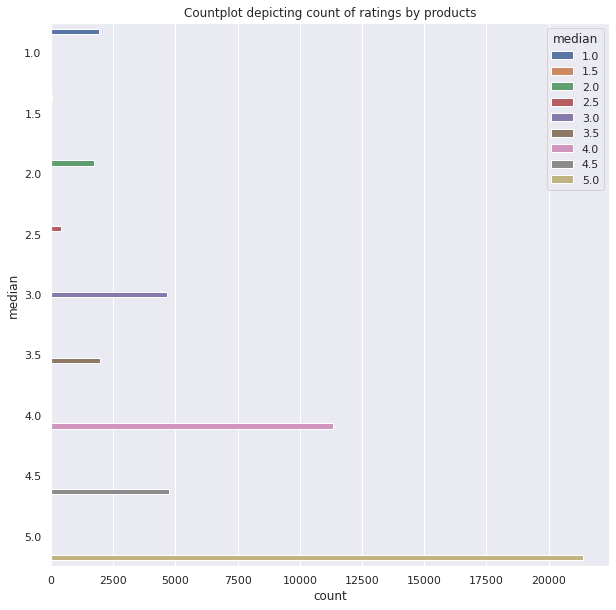

In [26]:
CountPlot(y = 'median', hue = 'median', data = data , title = 'Countplot depicting count of ratings by products' )

In [27]:
data['median'].value_counts()

5.0    21364
4.0    11338
4.5     4740
3.0     4660
3.5     1965
1.0     1946
2.0     1741
2.5      391
1.5       45
Name: median, dtype: int64

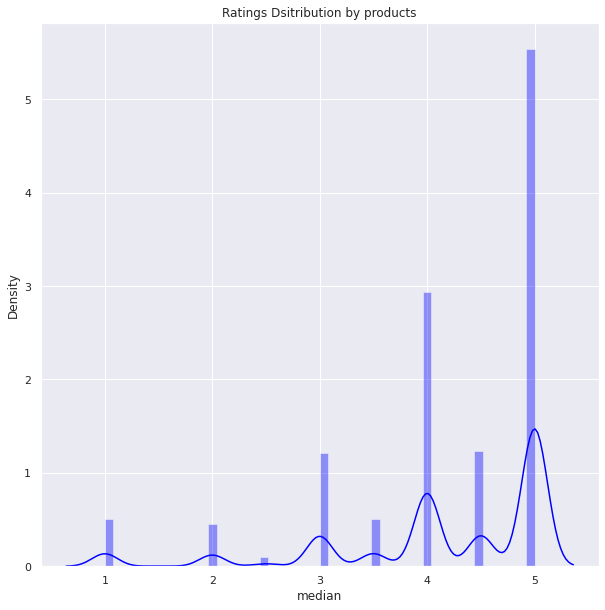

In [28]:
Distribution_Continous_Variables(data['median'],'blue','Ratings Dsitribution by products')

In [29]:
data = df_r.groupby(['userId','ratings']).count().reset_index()
data['ratings'] = data['ratings'].astype('float64')
data = data.groupby(['userId'])['ratings'].agg(['min','max','count','mean','median']).reset_index().sort_values(by=['median'],ascending=True)
data.tail()

,userId,min,max,count,mean,median
731,A2TN0U8173HM7A,5.0,5.0,1,5.0,5.0
446,A23WPWLYT3P1CZ,5.0,5.0,1,5.0,5.0
963,A3DL29NLZ7SXXG,5.0,5.0,1,5.0,5.0
543,A2DKQQIZ793AV5,5.0,5.0,1,5.0,5.0
675,A2PB325LKXYDOL,5.0,5.0,1,5.0,5.0


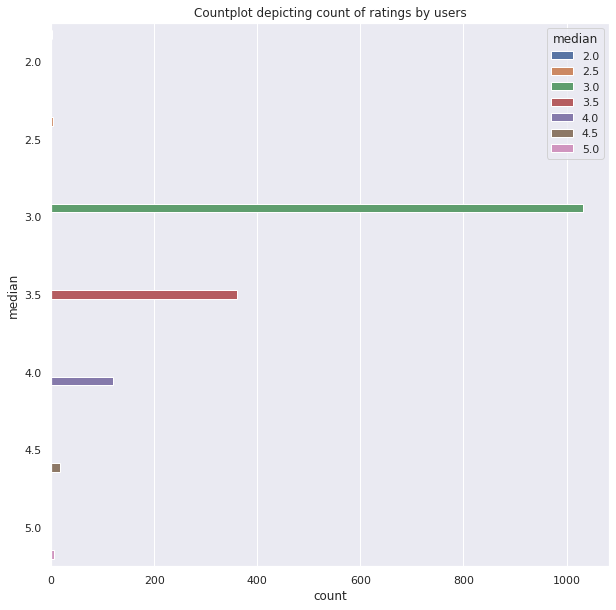

In [30]:
CountPlot(y = 'median', hue = 'median', data = data , title = 'Countplot depicting count of ratings by users' )

In [31]:
data['median'].value_counts()

3.0    1031
3.5     361
4.0     120
4.5      17
5.0       6
2.5       4
2.0       1
Name: median, dtype: int64

<b>Observations:</b><li>From above we can see that there were alot of users who provided less than 20 ratings. This made our dataset sparse and it would definitely affect or skew our recommendation model.<li>We dropped users who had less than 20 ratings and we did some basic Univariate analysis.<li>From the analysis we can observe that most of the products have been rated highly(above 3.0) by many users.<li>Also majority of users (around 6000) have a provided a median rating of 3.0.<br>
    <b>Note:</b><i><font color = 'blue'>Since our dataset is huge so in order to perform complex functions like aggregation we imported our data into dask dataframe</font></i>

### Splitting the data(70:30)

### Splitting for Popularity based recommender model

In [32]:
import sklearn.model_selection as modelSelection
X_train, X_test = modelSelection.train_test_split(df_r,test_size=0.3,random_state=42)

### Splitting for Collaborative filtering model

In [81]:
reader = Reader(rating_scale=(1.0,5.0))

In [82]:
data1 = Dataset.load_from_df(df_r[['userId', 'productId', 'ratings']],reader)

In [83]:
train,test = train_test_split(data1,test_size=0.3,random_state=42)


# Popularity Based Recommender model

In [36]:
X_train.shape

(88109, 4)

In [37]:
X_test.shape

(37762, 4)

In [38]:
X_train.groupby(['userId','productId'])['ratings'].count().reset_index().sort_values(by='ratings', ascending = False).tail(10)

,userId,productId,ratings
29374,A294BKN913UOGP,B00C9USP8I,1
29373,A294BKN913UOGP,B009WHV3I0,1
29372,A294BKN913UOGP,B009S6R9J2,1
29371,A294BKN913UOGP,B009CNVSZM,1
29370,A294BKN913UOGP,B009AJIU1S,1
29369,A294BKN913UOGP,B0092MD5UY,1
29368,A294BKN913UOGP,B008OD1BNK,1
29367,A294BKN913UOGP,B0084G3FKE,1
29366,A294BKN913UOGP,B007VXRKFM,1
88108,AZOK5STV85FBJ,B00BF6HVG4,1


<li>From above we can see that every userId,ProductId pair is unique which implies that every user has only one rating for a particular product and not two.<li>We will now build our recommender model where we would suggest users the products that are most relevant currently or are more popular.<li>We would calculate the popularity of a particular product based on total number of users and on the basis of average rating of a product.<li>In this case I would recommend users the products that are not only bought by majority but also have rating atleast 3.<li>We will build our custom recommender using transformers

In [39]:
X_train['ratings'] = X_train['ratings'].astype('float64')

In [40]:
data_grouby_product = X_train.groupby(['productId']).agg({'userId':'count','ratings':'mean'}).reset_index()
data_grouby_product.sort_values(by=['userId','ratings'], ascending = False, inplace=True)

### Selecting top 10 products with ratings atleast 3.0

In [41]:
data_grouby_product[data_grouby_product['ratings'] >= 3.0].iloc[:10,:]

,productId,userId,ratings
30892,B0088CJT4U,145,4.220690
30338,B007WTAJTO,127,4.716535
19570,B003ES5ZUU,125,4.856000
8662,B000N99BBC,113,4.761062
30604,B00829TIEK,99,4.383838
17298,B002R5AM7C,96,4.156250
30600,B00829THK0,89,4.393258
31151,B008DWCRQW,88,4.147727
22704,B004CLYEDC,82,4.695122
17489,B002SZEOLG,82,4.280488


### Now we will build our popularity based recommender system that would take the inputs and would suggest top 10 products with average rating atleast 3.0 and number of users who purchased it

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class PopularityBasedRecommender( BaseEstimator, TransformerMixin ):
    """This Transformer would recommend most popular products based on number of customers and their average rating"""
    
    def __init__( self ):
        
        pass
        
    
    def fit( self, X ):
        
        self.data = pd.DataFrame()
        X['userId'] = X['userId'].astype('object')
        X['productId'] = X['productId'].astype('object')
        X['ratings'] = X['ratings'].astype('float64')
        self.data = X
        
    def transform(self):
        
        self.modified = self.data.groupby(['productId']).agg({'userId':'count','ratings':'mean'}).reset_index()
        self.modified.sort_values(by=['userId','ratings'], ascending = False, inplace=True)
        self.modified_sorted = self.modified.reset_index(drop =True)
        self.modified_sorted.rename(columns = {'userId': 'user_count','ratings':'average_rating'}, inplace= True)
        self.modified_sorted['rank'] = self.modified_sorted[['user_count','average_rating']].apply(tuple, axis = 1) \
        .rank(ascending=False, method='dense').astype('int')
        return self.modified_sorted
        
    def recommend_top10(self):
        
        return self.modified_sorted[(self.modified_sorted['average_rating']>=3.0) \
                                    & (self.modified_sorted['rank']<=10)][['productId','rank']]
        
    




In [43]:
recommender = PopularityBasedRecommender() #----recommender model
recommender.fit(X_train)
recommender.transform()

,productId,user_count,average_rating,rank
0,B0088CJT4U,145,4.220690,1
1,B007WTAJTO,127,4.716535,2
2,B003ES5ZUU,125,4.856000,3
3,B000N99BBC,113,4.761062,4
4,B00829TIEK,99,4.383838,5
...,...,...,...,...
38258,B00J3BB6WS,1,1.000000,621
38259,B00JJ34TEW,1,1.000000,621
38260,B00JNRF2N6,1,1.000000,621
38261,B00JXCIT7M,1,1.000000,621


### Top 10 product recommendations on train data

In [44]:
recommender.recommend_top10()

,productId,rank
0,B0088CJT4U,1
1,B007WTAJTO,2
2,B003ES5ZUU,3
3,B000N99BBC,4
4,B00829TIEK,5
5,B002R5AM7C,6
6,B00829THK0,7
7,B008DWCRQW,8
8,B004CLYEDC,9
9,B002SZEOLG,10


### Top 10 product recommendations on test data

In [45]:
recommender.fit(X_test)
recommender.transform()

,productId,user_count,average_rating,rank
0,B0088CJT4U,61,4.213115,1
1,B003ES5ZUU,59,4.881356,2
2,B000N99BBC,54,4.796296,3
3,B00829TIEK,50,4.540000,4
4,B008DWCRQW,49,4.000000,5
...,...,...,...,...
21326,B00JMC9CLK,1,1.000000,285
21327,B00JTHKB04,1,1.000000,285
21328,B00KGHXCY8,1,1.000000,285
21329,B00KIUV4KC,1,1.000000,285


In [46]:
recommender.recommend_top10()

,productId,rank
0,B0088CJT4U,1
1,B003ES5ZUU,2
2,B000N99BBC,3
3,B00829TIEK,4
4,B008DWCRQW,5
5,B00829THK0,6
6,B007WTAJTO,7
7,B00829TIA4,8
8,B004CLYEDC,9
9,B004T9RR6I,10


<h3><b>Note: </b><font color = 'blue'>The recommendations for all users is going to be same since we are recommending them the products based on popularity</font>

# Collaborative Filtering model

### User based collab filtering

### Training with KNN means algorithm

In [123]:
knn = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
knn.fit(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [124]:
test_pred_knn = knn.test(test)

In [125]:
test_pred_knn[0:10]

[Prediction(uid='A8CKH8XB33XGN', iid='B0044ZC2IA', r_ui=5.0, est=4.1625, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AWNJAY0M5UI70', iid='B00A7KYH8E', r_ui=5.0, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AR18DH5SL9F73', iid='B004EI0EG4', r_ui=5.0, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1FXT4VNDA25LY', iid='B000IM5GBS', r_ui=2.0, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1MZL91Z44RN06', iid='B001UE6MIO', r_ui=4.0, est=4.593023255813954, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ANW6EGY12V5XS', iid='B0043241X8', r_ui=2.0, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AE88D7OM7YU99', iid='B00APQM1GU', r_ui=5.0, est=3.9423076923076925, details={'

In [126]:
#RMSE score
print("RMSE for KNNWithMeans")
print(accuracy.rmse(test_pred_knn))

RMSE for KNNWithMeans
RMSE: 1.0618
1.0618108041248628


### Training with SVD algorithm with gridsearch

#### In case of gridsearchcv we cannot train on trainset since it has complex structure so we would take data and then we would perform unibiased accuracy estimation as mentioned in the code below

In [97]:
#----refrence article : https://surprise.readthedocs.io/en/stable/FAQ.html
raw_ratings = data1.raw_ratings
# Train = 70% of the data and Test = 30 % of the data
threshold = int(.7 * len(raw_ratings))
Train_raw_ratings = raw_ratings[:threshold]
Test_raw_ratings = raw_ratings[threshold:]
data1.raw_ratings = Train_raw_ratings

In [98]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [5,10,15,20,30], "reg_all":[0.01,0.02]}
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)
svd_gs.fit(data1)

In [99]:
algo = svd_gs.best_estimator['rmse']

In [101]:
#Retrain on Trainset
train_set = data1.build_full_trainset()
algo.fit(train_set)

In [104]:
predictions = algo.test(train_set.build_testset())
print('Biased accuracy on Train:')
accuracy.rmse(predictions)

Biased accuracy on Train:
RMSE: 0.9023


0.902306062897823

In [106]:
test_set = data1.construct_testset(Test_raw_ratings)
predictions = algo.test(test_set)
print('Unbiased accuracy on Test:')
accuracy.rmse(predictions)

Unbiased accuracy on Test:
RMSE: 0.9414


0.9414087066056804

In [112]:
predictions[0:10]

[Prediction(uid='A2RU4U1JZ3DMP5', iid='B006OT06OQ', r_ui=3.0, est=4.1249204138724735, details={'was_impossible': False}),
 Prediction(uid='A1CMD08Z49PGKQ', iid='B006OT3AVW', r_ui=5.0, est=4.699079312611173, details={'was_impossible': False}),
 Prediction(uid='A2EN82VBJT44QP', iid='B006OU2RT2', r_ui=5.0, est=4.414931117388475, details={'was_impossible': False}),
 Prediction(uid='A2HV76MYH7UL3S', iid='B006OU95NS', r_ui=1.0, est=4.74800985832708, details={'was_impossible': False}),
 Prediction(uid='AQ2FC1DLKVD8H', iid='B006OVYI1G', r_ui=5.0, est=3.914198207989098, details={'was_impossible': False}),
 Prediction(uid='A1YN5I4FINMBTI', iid='B006OW1J1M', r_ui=5.0, est=4.6377885316930625, details={'was_impossible': False}),
 Prediction(uid='ABQWMANK4AR63', iid='B006OW1J1M', r_ui=3.0, est=4.142003768141899, details={'was_impossible': False}),
 Prediction(uid='AQIJ3ZEEVCIKU', iid='B006OW1J1M', r_ui=3.0, est=4.2556623052651785, details={'was_impossible': False}),
 Prediction(uid='AG8YP2XTC5X1I', 

### Training SVD normally with n_factors = 5 and reg_all = 0.02

In [107]:
svd = SVD(n_factors=5,reg_all=0.02)
svd.fit(train)

In [108]:
test_pred_svd = svd.test(test)

In [109]:
test_pred_svd[0:10]

[Prediction(uid='A8CKH8XB33XGN', iid='B0044ZC2IA', r_ui=5.0, est=4.108300524206964, details={'was_impossible': False}),
 Prediction(uid='AWNJAY0M5UI70', iid='B00A7KYH8E', r_ui=5.0, est=4.603904126210906, details={'was_impossible': False}),
 Prediction(uid='AR18DH5SL9F73', iid='B004EI0EG4', r_ui=5.0, est=4.10634621972618, details={'was_impossible': False}),
 Prediction(uid='A1FXT4VNDA25LY', iid='B000IM5GBS', r_ui=2.0, est=4.505977877331646, details={'was_impossible': False}),
 Prediction(uid='A1MZL91Z44RN06', iid='B001UE6MIO', r_ui=4.0, est=4.5801177631171885, details={'was_impossible': False}),
 Prediction(uid='ANW6EGY12V5XS', iid='B0043241X8', r_ui=2.0, est=4.0769720880148, details={'was_impossible': False}),
 Prediction(uid='AE88D7OM7YU99', iid='B00APQM1GU', r_ui=5.0, est=3.9944240762799534, details={'was_impossible': False}),
 Prediction(uid='A1FDV3WPOHREY9', iid='B001U0O5QO', r_ui=2.0, est=4.2840004559048, details={'was_impossible': False}),
 Prediction(uid='A6VXZ1EEPRTLV', iid='B0

In [110]:
accuracy.rmse(test_pred_svd)

RMSE: 0.9846


0.9846101753001091

#### Test RMSE score for SVD with gridsearch is 0.94 while normal SGD and knn with means perform poorly with RMSE scores almost 1 

### Top 5 product recommendations based on collaborative filtering 

In [111]:
from collections import defaultdict
def get_top_n(predictions, n=5):
  
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [113]:
top_n = get_top_n(predictions, n=5)

### Printing top 5 recommended products for each user

In [115]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2RU4U1JZ3DMP5 ['B006OT06OQ', 'B007JIN6T8', 'B009U7WZCA', 'B00D1KBG5Y', 'B00D3F7F4I']
A1CMD08Z49PGKQ ['B006OT3AVW', 'B006P88UQW', 'B006RG21ZS', 'B006T5JQ9Q', 'B00701M91U']
A2EN82VBJT44QP ['B006OU2RT2', 'B006Q6PB9W', 'B0076DKLA8', 'B007BJHETS', 'B007ELZOM2']
A2HV76MYH7UL3S ['B006OU95NS', 'B006VCP72W', 'B00702SCN8', 'B00752R4QO', 'B007PV6PM4']
AQ2FC1DLKVD8H ['B006OVYI1G', 'B006TQ30TW', 'B006UMM1PO', 'B0072DKWQ0', 'B007GMPZ9Q']
A1YN5I4FINMBTI ['B006OW1J1M', 'B0073FE1F0', 'B007PLL4CK', 'B007ZWLRSU', 'B0085U6TBQ']
ABQWMANK4AR63 ['B006OW1J1M', 'B006RG0QC8', 'B006T7HXI0', 'B006WYVLNI', 'B00746LVOM']
AQIJ3ZEEVCIKU ['B006OW1J1M', 'B006Q6QHDG', 'B006TI42QU', 'B006ZP8UOW', 'B007KXBUHW']
AG8YP2XTC5X1I ['B006OYH5NQ', 'B0071BIQZC', 'B007X26S8Q', 'B0087G0NYM', 'B009NHAEXE']
A6VPK7X53QNAQ ['B006OZEIKS', 'B006TR0FCQ', 'B0079UAT0A', 'B007BY0MIS', 'B007Q8GOGI']
A3T4OHEAHOJ700 ['B006OZEIKS', 'B006ZZ2V9M', 'B0079TOEQQ', 'B007BY0MIS', 'B007CRWQ0Q']
A3QNQQKJTL76H0 ['B006OZEIKS', 'B0074FGLUM', 'B0077KMY4G', '

### Final Conclusion



*   Popularity based recommender systems are primitive and not intelligent i.e they just sort the trending items based on popularity and hence, suggest them to the buyers with an assumption that the customer could buy the item.
*   Often popularity based recommender systems recommend irrelavant items to the buyers without taking into consideration their habits, likings and history.


*   In order to overcome these shortcomings with the popularity based systems we used collaborative filtering model which follows ML approach to suggest relevant products to the customers based on their distinct characteristics.
*   We used KNN with means and its test RMSE score turned out to be 1.06 with the threshold of 50 neighbours which is definitely not a good score when compared with SVD with gridsearch which reduced the RMSE to 0.94.





